# Gloss-to-German-Spoken translation with a sequence-to-sequence Transformer
**Description:** Implementing a sequence-to-sequene Transformer and training it on a machine translation task.

## Introduction

In this example, we'll build a sequence-to-sequence Transformer model, which
we'll train on an Gloss-to-Spoken-Text machine translation task.

We'll cover how to:

- Vectorize text using the Keras `TextVectorization` layer.
- Implement a `TransformerEncoder` layer, a `TransformerDecoder` layer,
and a `PositionalEmbedding` layer.
- Prepare data for training a sequence-to-sequence model.
- Use the trained model to generate translations of never-seen-before
input sentences (sequence-to-sequence inference).

The code featured here is adapted from the book
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)
(chapter 11: Deep learning for text).
The present example is fairly barebones, so for detailed explanations of
how each building block works, as well as the theory behind Transformers,
I recommend reading the book.

## Setup

In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

import pandas as pd
from matplotlib import pyplot as plt

## Mount


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuration


In [5]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 1000  # Number of samples to train on.

# DATA SET IMPORT
data_path_spoken_train = '/content/drive/Shareddrives/TFG/TFG/DGS/spoken_train.txt';
data_path_gloss_train = '/content/drive/Shareddrives/TFG/TFG/DGS/gloss_train.txt';

## Parsing the data

Each line contains an Gloss sentence and its corresponding Spoken German sentence.
The Gloss sentence is the *source sequence* and Spoken German one is the *target sequence*.
We prepend the token `"[start]"` and we append the token `"[end]"` to the Spanish sentence.

In [4]:
# Read Files
def read_files_lines(data_path):
  with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")[:-1]
    return lines

In [ ]:
def write_files_lines(data_path, lines):
  with open(data_path, "w", encoding="utf-8") as f:
    for line in lines:
      f.write(f'{line} \n')

In [6]:
spoken_lines = read_files_lines(data_path_spoken_train)
gloss_lines = read_files_lines(data_path_gloss_train)

In [7]:
len(spoken_lines)

29271

In [8]:
len(gloss_lines)

29271

New dataset

In [ ]:
# Use to create a new subset of DGT
# new_data = "/content/drive/Shareddrives/TFG/TFG/DGS/spoken_train_25_len.txt"
# write_files_lines(new_data, filter_input_texts)

In [9]:
spoken_lines = read_files_lines("/content/drive/Shareddrives/TFG/TFG/DGS/spoken_train_25_len.txt")
print(spoken_lines)

['<PER> stricken malen . ', 'Ja da sieht man es auch . ', 'Der Sportverein umfasst ', 'Versuchsweise ? ', 'Alle drei Jahre . ', 'Stimmt <NUM> Jahre . ', '<PER> hat drei Kinder . ', 'Diese drei Flüsse . ', 'Damit wird Schluss sein . ', 'Das war mein Plan . ', 'Ich komme täglich . ', 'Der Rest bleibt so . ', 'CIs sind langlebiger . ', 'Das ist für mich egal . ', 'Ein bisschen schon . ', 'Vor drei Jahren ? ', 'Nur neun ', 'Keine Ahnung . ', 'Schaue ich mir noch an . ', 'Das ist der leichte Weg . ', 'Im Video Im Videotext ', '<PER> spielst Skat . ', 'Aber ich ', '<PER> weiß ich nicht . ', 'Stimmt . ', 'Das war etwas anderes . ', 'Verschwinden ja . ', 'Heute ist alles anders . ', '<PER> ich glaube nicht . ', 'Dort habe ich Vorteile . ', 'Das war nicht weit . ', 'Aber warum nicht ? ', '<PER> ist aber hörend . ', 'Man wurde gezwungen . ', 'Da hast du Recht . ', 'Ich habe das erlebt . ', 'Und wenn ich an den ', 'Der Arme . ', 'Lassen wir das . ', 'Das ist ja Training . ', 'Es war im Mai im Mai

In [10]:
input_sentence_len = [len(txt) for txt in spoken_lines]
filter_input_texts = [txt for txt, l in zip(spoken_lines, input_sentence_len) if l >= 5 and l <= 25]


(array([  2.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,  13.,
          0.,   0.,   0.,   0.,  19.,   0.,   0.,   0.,   0.,   7.,   0.,
          0.,   0.,   0.,  13.,   0.,   0.,   0.,   0.,  14.,   0.,   0.,
          0.,   0.,  15.,   0.,   0.,   0.,   0.,  17.,   0.,   0.,   0.,
          0.,  30.,   0.,   0.,   0.,   0.,  36.,   0.,   0.,   0.,   0.,
         59.,   0.,   0.,   0.,   0.,  64.,   0.,   0.,   0.,   0.,  75.,
          0.,   0.,   0.,   0.,  71.,   0.,   0.,   0.,   0.,  99.,   0.,
          0.,   0.,   0., 111.,   0.,   0.,   0.,   0., 106.,   0.,   0.,
          0.,   0., 154.,   0.,   0.,   0.,   0., 161.,   0.,   0.,   0.,
        167.]),
 array([ 6. ,  6.2,  6.4,  6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,
         8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2,
        10.4, 10.6, 10.8, 11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4,
        12.6, 12.8, 13. , 13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6,
        14.8, 15. , 15

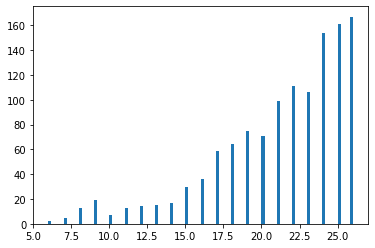

In [11]:
# Histogram
plt.hist(input_sentence_len, bins=100)

In [12]:
# Parsing the data
text_pairs = []
for spoken, glosss in zip(spoken_lines, gloss_lines):
    spa = "[start] " + spoken + " [end]"
    text_pairs.append((glosss, spa))

Here's what our sentence pairs look like:

In [13]:

for _ in range(num_samples):
    print(random.choice(text_pairs))

('ALPHA ZUSAMMEN MUSS NICHT', '[start] Ich bin <NUM> .  [end]')
('ENTSCHEIDEN DAZU WORT PUNKT', '[start] Ähm die Infusion ist für  [end]')
('WIE LUFT DURCH GUT', '[start] Wir gingen schnell .  [end]')
('ICH FROH NEIN ICHILFLOS', '[start] Ich weiß nicht .  [end]')
('DU SPANIEN GEBÄRDEN ALT', '[start] Stimmt genau .  [end]')
('SCHNEIDEN SCHLAGEN JA NEIN', '[start] Später fahren wir weg .  [end]')
('ICH BEZAHLEN ICH FÜR', '[start] Verstehst du das nicht ?  [end]')
('KREUZ SEITE KÖRPER GUT', '[start] Das habe ich miterlebt .  [end]')
('SCHNEIDEN HIRN SCHNEIDEN GEFÜHL', '[start] Aber im Moment  [end]')
('ICH ACHTUNG PLEITE SCHNEIDEN', '[start] Ich war sechs Jahre alt .  [end]')
('TYPISCH KOMM HER DAMIT', '[start] … der Hirschgarten und  [end]')
('ICH FALTE WANGE KÖRPER', '[start] Bei uns gab es morgens  [end]')
('STIMMT ICH SORGEN SICH', '[start] Ja so war das .  [end]')
('FAHNE SAGEN SCHIESSEN TOR', '[start] Wasser  [end]')
('ERKLÄREN MEHR AUFZÄHLEN HANDLUN', '[start] Ja super nett .  [end

Now, let's split the sentence pairs into a training set, a validation set,
and a test set.

In [14]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs : Represents : {len(train_pairs)/len(text_pairs)} % of the data")
print(f"{len(val_pairs)} validation pairs : Represents : {len(val_pairs)/len(text_pairs)} % of the data")
print(f"{len(test_pairs)} test pairs : Represents : {len(test_pairs)/len(text_pairs)} % of the data")

1238 total pairs
868 training pairs : Represents : 0.7011308562197092 % of the data
185 validation pairs : Represents : 0.1494345718901454 % of the data
185 test pairs : Represents : 0.1494345718901454 % of the data


## Vectorizing the text data

We'll use two instances of the `TextVectorization` layer to vectorize the text
data (one for Gloss and one for Spoken German),
that is to say, to turn the original strings into integer sequences
where each integer represents the index of a word in a vocabulary.

The Gloss layer will use the default string standardization (strip punctuation characters)
and splitting scheme (split on whitespace), while
the Spanish layer will use a custom standardization, where we add the character
`"¿"` to the set of punctuation characters to be stripped.

Note: in a production-grade machine translation model, I would not recommend
stripping the punctuation characters in either language. Instead, I would recommend turning
each punctuation character into its own token,
which you could achieve by providing a custom `split` function to the `TextVectorization` layer.

In [20]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


gloss_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spoken_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
gloss_vectorization.adapt(train_eng_texts)
spoken_vectorization.adapt(train_spa_texts)

In [21]:
custom_standardization("[start] Schwer zu sagen . [end]")

<tf.Tensor: shape=(), dtype=string, numpy=b'[start] schwer zu sagen  [end]'>

In [23]:
spoken_vectorization(["[start] Schwer zu sagen . [end]"])

<tf.Tensor: shape=(1, 21), dtype=int64, numpy=
array([[  2, 200,  47, 205,   3,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]])>

Next, we'll format our datasets.

At each training step, the model will seek to predict target words N+1 (and beyond)
using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.
`encoder_inputs` is the vectorized source sentence and `encoder_inputs` is the target sentence "so far",
that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.
- `target` is the target sentence offset by one step:
it provides the next words in the target sentence -- what the model will try to predict.

In [24]:

def format_dataset(gloss, spoken):
    glos = gloss_vectorization(gloss)
    spo = spoken_vectorization(spoken)
    # decoder_output = spa
    # decoder_output[decoder_output == 3] = 0
    # decoder_outputs = tf.where(tf.equal(x, 3), 0, spa)

    return ({"encoder_inputs": glos, "decoder_inputs": spo[:, :-1],}, spo[:, 1:])


def make_dataset(pairs):
    glos_texts, spo_texts = zip(*pairs)
    glos_texts = list(glos_texts)
    spo_texts = list(spo_texts)
    dataset = tf.data.Dataset.from_tensor_slices((glos_texts, spo_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [25]:
d = train_ds.batch(1)
print("decoder_inputs: ", list(d.as_numpy_iterator())[0][0]['decoder_inputs'][0][0])
print("---------------------------------------------")
print(list(d.as_numpy_iterator())[0][1][0][0])

decoder_inputs:  [  2   9  10 368   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
---------------------------------------------
[  9  10 368   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


Let's take a quick look at the sequence shapes
(we have batches of 64 pairs, and all sequences are 20 steps long):

In [26]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


## Building the model

Our sequence-to-sequence Transformer consists of a `TransformerEncoder`
and a `TransformerDecoder` chained together. To make the model aware of word order,
we also use a `PositionalEmbedding` layer.

The source sequence will be pass to the `TransformerEncoder`,
which will produce a new representation of it.
This new representation will then be passed
to the `TransformerDecoder`, together with the target sequence so far (target words 0 to N).
The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).

A key detail that makes this possible is causal masking
(see method `get_causal_attention_mask()` on the `TransformerDecoder`).
The `TransformerDecoder` sees the entire sequences at once, and thus we must make
sure that it only uses information from target tokens 0 to N when predicting token N+1
(otherwise, it could use information from the future, which would
result in a model that cannot be used at inference time).

In [27]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


Next, we assemble the end-to-end model.

In [28]:
embed_dim = 1024 #128 #256, 512, 1024
latent_dim = 512 #2048, 256, 512, 1024
num_heads = 6 #8, 12

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

## Training our model

We'll use accuracy as a quick way to monitor training progress on the validation data.
Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

Here we only train for 1 epoch, but to get the model to actually converge
you should train for at least 30 epochs.

In [29]:
epochs = 30  # This should be at least 30 for convergence "rmsprop"
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
transformer.summary()
callback_model = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
transformer.compile(
    optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callback_model)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 1024)  15380480    ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 1024)  26239488    ['positional_embedding[

Save History

In [30]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = "/content/drive/Shareddrives/TFG/TFG/DGS/history.json" 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = "/content/drive/Shareddrives/TFG/TFG/DGS/history.csv" 
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


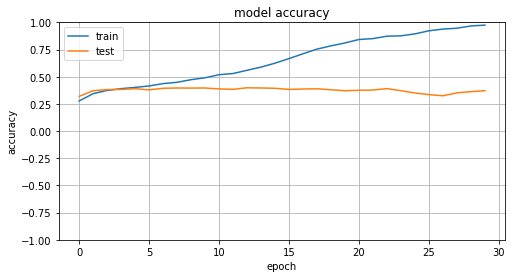

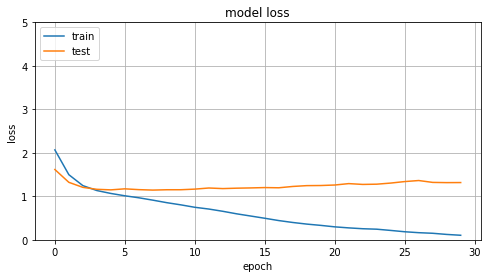

In [31]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.ylim([-1, 1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.ylim([0, 5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Decoding test sentences

Finally, let's demonstrate how to translate brand new Gloss sentences.
We simply feed into the model the vectorized Gloss sentence
as well as the target token `"[start]"`, then we repeatedly generated the next token, until
we hit the token `"[end]"`.

In [33]:
spa_vocab = spoken_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = gloss_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spoken_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence



In [34]:
test_eng_texts = [pair[0] for pair in test_pairs]
references = []
candidates = []
final_result = []
for _ in range(num_samples):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence , ".", translated)
    references.append([input_sentence])
    candidates.append(translated)
    final_result.append(f'{input_sentence} {translated}')

SCHWER WORT ICH WISSEN . [start] per war immer [end]
GEFÄHRLICH FÜR TAUB GEFÄHRLICH . [start] ich wie das mitbekommen [end]
SCHWER WORT ICH WISSEN . [start] per war immer [end]
SO FREI SCHLAFEN JA . [start] per war ich per [end]
ICH KLEIN SCHREIBEN HÖREND . [start] per [end]
HELFEN HELFEN BEISPIEL ABLAUF . [start] ich habe keine ahnung [end]
ICH DAZU WIMMELN KÖRPER . [start] ja die stadt [end]
RECHTS TAUB TITEL ÜBERSCHRIFT . [start] ja ich weiß es [end]
EIGEN ARBEITEN DA INTERESSE . [start] wie so das war für [end]
LIST NASAL <NUM> LIST . [start] per ist es per [end]
BEKANNT GEHÖREN VERGANGENHEIT GESCHICHTE . [start] ja ich weiß nicht [end]
ICH ENDE ICH BURNOUT . [start] ja das ist ein problem [end]
INIT GERADE DU ENDE . [start] das ist das nicht [end]
ICH MITBRINGEN BRAUCHEN ABWINKEN . [start] es war ich weiß [end]
DUBAI ORAL GEWESEN HIN . [start] ich weiß das auch [end]
HÖREND FILM WIEDER NEIN . [start] früher auch [end]
VIEL MITBRINGEN WERFEN LASSEN . [start] ich war zuerst dort [en

In [35]:
references

[['SCHWER WORT ICH WISSEN'],
 ['GEFÄHRLICH FÜR TAUB GEFÄHRLICH'],
 ['SCHWER WORT ICH WISSEN'],
 ['SO FREI SCHLAFEN JA'],
 ['ICH KLEIN SCHREIBEN HÖREND'],
 ['HELFEN HELFEN BEISPIEL ABLAUF'],
 ['ICH DAZU WIMMELN KÖRPER'],
 ['RECHTS TAUB TITEL ÜBERSCHRIFT'],
 ['EIGEN ARBEITEN DA INTERESSE'],
 ['LIST NASAL <NUM> LIST'],
 ['BEKANNT GEHÖREN VERGANGENHEIT GESCHICHTE'],
 ['ICH ENDE ICH BURNOUT'],
 ['INIT GERADE DU ENDE'],
 ['ICH MITBRINGEN BRAUCHEN ABWINKEN'],
 ['DUBAI ORAL GEWESEN HIN'],
 ['HÖREND FILM WIEDER NEIN'],
 ['VIEL MITBRINGEN WERFEN LASSEN'],
 ['KREUZ GROSS FARBEN HEMD'],
 ['<NUM> KOMMA <NUM> GEGEN'],
 ['APPLAUS <NUM> AUSSEN APPLAUS'],
 ['GEFÜHL EXPLOSION WIEXPLOSION BRUSTKORB'],
 ['ZUSAMMEN BISSCHEN ANFASSEN GIESSEN'],
 ['ICH ENDE <NUM> ENDE'],
 ['ICH ENDE <NUM> ENDE'],
 ['STRAHL ICH WISSENICHT ICH'],
 ['BEKANNT GEHÖREN VERGANGENHEIT GESCHICHTE'],
 ['MUSS ICH FRAGE AUF'],
 ['KREUZ GROSS FARBEN HEMD'],
 ['BEISPIEL WIEDER BRÜCKE BAU'],
 ['PLÖTZLICH SCHNURRBART KOMMEN PARALLEL'],
 ['S

Save candidates

In [ ]:
write_files_lines("/content/drive/Shareddrives/TFG/TFG/DGS/candidates.txt", final_result)

## Model Performance

Mesure the performance of the model. Using BLEU-4

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu


In [ ]:
def compute_bleu(candidates, references):
  scores = []
  for ref, can in zip(references, candidates):
    score = sentence_bleu(ref, can)
    scores.append(score)
  return scores

In [ ]:
from numpy.core.fromnumeric import mean
scores = compute_bleu(candidates, references)
avg_score = mean(scores)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print("Scores")
print(scores)

Scores
[0.5828233954152654, 0.4630777161991027, 0.5533409598501607, 0.5533409598501607, 0.5577503997480662, 0.5623413251903491, 0.4760116549244004, 0.4760116549244004, 0.5623413251903491, 0.5450176720923848, 0.5533409598501607, 0.5533409598501607, 0.5703374635148922, 0.5450176720923848, 0.5623413251903491, 0.5828233954152654, 0.5410822690539396, 0.5623413251903491, 0.5946035575013605, 0.5491004867761125, 0.5773502691896257, 0.5623413251903491, 0.5015430242918049, 0.5491004867761125, 0.5885661912765424, 0.5828233954152654, 0.5450176720923848, 0.5113918457579462, 0.5533409598501607, 0.5885661912765424, 0.5577503997480662, 0.5479048470119331, 0.5654881808206081, 0.5491004867761125, 0.5577503997480662, 0.5088274727401554, 0.5671276403520978, 0.48832168314095387, 0.5410822690539396, 0.5533409598501607, 0.5828233954152654, 0.5623413251903491, 0.5247357977607321, 0.5491004867761125, 0.5773502691896257, 0.5577503997480662, 0.5533409598501607, 0.5623413251903491, 0.5433150720978996, 0.508827472

In [ ]:
print("Average score")
print(avg_score)

Average score
0.5399919722842015
